# GD1 Stream in Fuji Data - Velocity Dispersion

In [11]:
%pylab inline
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import astropy.units as u
from astropy.table import Table
from astropy.io import fits
import scipy.interpolate
from scipy.optimize import minimize
from scipy.special import logsumexp

import emcee
import corner

from IPython.display import display, Math

Populating the interactive namespace from numpy and matplotlib


In [3]:
from astropy.coordinates import SkyCoord, ICRS, Galactocentric, galactocentric_frame_defaults
GCPARAMS = galactocentric_frame_defaults.get_from_registry("v4.0")['parameters']

In [4]:
plt.rc('font', size=14, family='serif')

In [5]:
pd.options.mode.chained_assignment = None

# Radial Velocity Dispersion

In [9]:
gd1_hdu = fits.open('fuji_gd1_members.fits')

In [12]:
gd1 = Table(gd1_hdu[1].data)

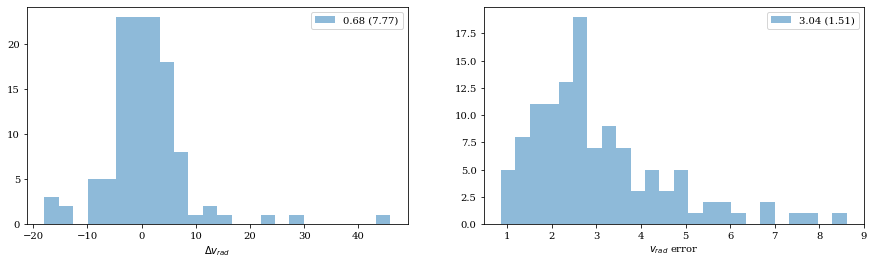

In [15]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,4))
bins = np.linspace(min(gd1['delta_vrad']), max(gd1['delta_vrad']),25)
ax1.hist(gd1['delta_vrad'],bins=bins,alpha=0.5,label='{:.2f} ({:.2f})'.format(np.mean(gd1['delta_vrad']), np.std(gd1['delta_vrad'])))

ax1.set_xlabel('$\Delta v_{rad}$')
ax1.legend()

bins = np.linspace(min(gd1['vrad_err']), max(gd1['vrad_err']),25)
ax2.hist(gd1['vrad_err'],bins=bins,alpha=0.5,label='{:.2f} ({:.2f})'.format(np.mean(gd1['vrad_err']), np.std(gd1['vrad_err'])))

ax2.set_xlabel('$v_{rad}$ error')
ax2.legend()

### Log-likelihood MCMC model

Taking model from Malhan & Ibata 2019 (sec. 4.1):

$$ln \mathcal{L} = \Sigma_{data} [- 1/2 (\frac{v_{los}^{m} - v_{los}^{d}}{\sigma_{v_{los, obs}}})^{2} -ln(\sigma_{v_{los, obs}}) ]$$

where, $$\sigma_{v_{los, obs}}^{2} = \sigma_{v_{los, int}}^{2} + f_{d}^{2} $$

and $f$ is $v_{rad}$ error from the pipeline

In [28]:
def log_like(p, vdiff, verr):
    sig, f = p
    sigma2 = (verr) ** 2 + sig**2
    ln = - 0.5 * vdiff ** 2 / sigma2 - 0.5*np.log(2*np.pi) - np.log(np.sqrt(sigma2)) + np.log(f)
    bg = np.full_like(vdiff, -np.log(max(gd1['delta_vrad'])-min(gd1['delta_vrad']))) + np.log(1-f)
    args = [ln, bg]
    ll = logsumexp(args, axis=0)
    return ll, args

In [29]:
def log_prior(p):
    sig, f = p
    if (sig < 0) or (sig > 200):
        return -np.inf
    if (f > 1) or (f < 0):
        return -np.inf
    return 0

In [30]:
def logprob(p, vdiff, verr):
    lp = log_prior(p)
    if not np.isfinite(lp):
        return -np.inf
    
    ll, args = log_like(p, vdiff, verr)

    return lp + ll.sum()

In [31]:
def model(p, vdiff, verr, title):

    vgrid = np.linspace(min(vdiff), max(vdiff), 100)
    errgrid = np.ones(len(vgrid)) * 2.9
    
    ll, args = log_like(p, vgrid, errgrid)
    pll = np.exp(ll)
    
    plt.hist(vdiff, density=True, color='grey')
    plt.plot(vgrid, pll, label=title)

In [32]:
x = gd1['phi1']
y = gd1['vrad']
verr = gd1['vrad_err']
vdiff = gd1['delta_vrad']

ndim = 2
nwalkers = 64
p0_guess = [5, 0.9]
p0 = p0_guess + 1e-4 * np.random.randn(64, 2)

In [33]:
res = minimize(lambda *args: -logprob(*args), x0=p0_guess, 
                   args=(vdiff,verr, ), method='L-BFGS-B')

/Users/pfagrelius/miniconda3/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


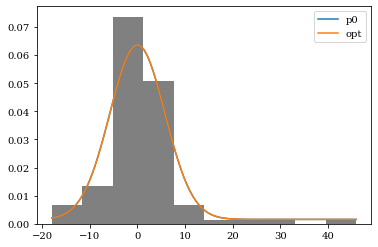

In [34]:
model(p0_guess, vdiff, verr,'p0')
model(res.x, vdiff, verr,'opt')
plt.legend()

In [35]:
nparams = len(p0_guess)
print(nparams)
nwalkers = 64
p0_guess = res.x
p0 = p0_guess + 1e-4 * np.random.randn(64, 2)
## Check to see things are initialized ok
lkhds = [logprob(p0[j], vdiff, verr) for j in range(nwalkers)]
assert np.all(np.array(lkhds) > -9e9)

2


Following emcee tutorial: https://emcee.readthedocs.io/en/stable/tutorials/line/

Run for all stars, in stream, and out of stream stars

In [36]:
labels = ['$\sigma_{v_{rad}}$','f']
def display_results(sampler, title):
    flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
    print('## {} ##'.format(title))
    for i in range(len(p0_guess)):
        mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
        q = np.diff(mcmc)
        txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
        txt = txt.format(mcmc[1], q[0], q[1], labels[i])
        display(Math(txt))
        
    fig = corner.corner(flat_samples, labels=labels, quantiles=[0.16,0.50,0.84], show_titles=True)
    #plt.hist(sig, bins=25, label=title, alpha=0.5)
    #plt.xlabel("$\sigma_{v_{rad}}$")

## GD1 ##


<IPython.core.display.Math object>

<IPython.core.display.Math object>

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


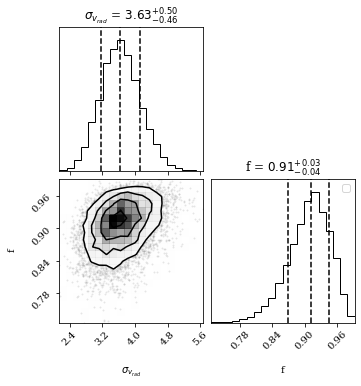

In [37]:
titles = ['GD1']

sampler = emcee.EnsembleSampler(nwalkers, len(p0_guess), logprob, args=(vdiff,verr))

state = sampler.run_mcmc(p0, 2048)
sampler.reset()
sampler.run_mcmc(state, 2048)

display_results(sampler, titles[0])
plt.legend()